## Bond arbitrage matrix
#### 23.06.19

In [5]:
# connect nessesary packeges
import datetime
import numpy as np
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

current_date = datetime.datetime.strptime('2019-06-26', '%Y-%m-%d')

In [6]:
current_date

datetime.datetime(2019, 6, 26, 0, 0)

## Helpfull Functions

In [7]:
# Future value
def future_value(price, r, t):
        return price * np.exp(r * t)
    
    
# Present value
def present_value(price, r, t):
        return price * np.exp(-r * t)    

## Calculate arbitrage strategy for goverment bonds

In [8]:
# get goverment bonds data
gov = pd.read_csv('https://raw.githubusercontent.com/Aurilino/Python/master/Shortterm_bonds_arbitrage/Gov_bonds.xls.csv ',
            sep=';', encoding='cp1251')
gov.index = gov.ISIN # set index as bonds isin
gov['Expiration_date'] = pd.to_datetime(gov['Expiration_date'], format='%d.%m.%Y', errors='ignore')
gov['Coupon_date'] = pd.to_datetime(gov['Coupon_date'], format='%d.%m.%Y', errors='ignore')
gov['price_rub'] = gov.Nominal * (gov['Price'] / 100) # Calculate the current value
gov['coupon_return'] = gov.Coupon / gov.price_rub #calculate coupon yield
gov = gov.drop('ISIN', axis=1)
gov.head()

,Name,Price,Nominal,Coupon,ACI,Coupon_date,Coupon_days,Expiration_date,price_rub,coupon_return
ISIN,,,,,,,,,,
RU000A100907,КОБР-20,99.990,1000.0,19.32,15.21,2019-07-17,17.07.2019,92,999.90,0.019322
RU000A100C23,КОБР-21,99.969,1000.0,19.13,9.27,2019-08-14,14.08.2019,92,999.69,0.019136
RU000A100EL3,КОБР-22,99.960,1000.0,18.94,3.32,2019-09-11,11.09.2019,92,999.60,0.018948
RU000A0JX0J2,ОФЗ_24019,100.191,1000.0,38.64,15.07,2019-10-16,16.10.2019,182,1001.91,0.038566
RU000A0ZYCK6,ОФЗ_25083,99.703,1000.0,34.90,1.53,2021-12-15,18.12.2019,182,997.03,0.035004


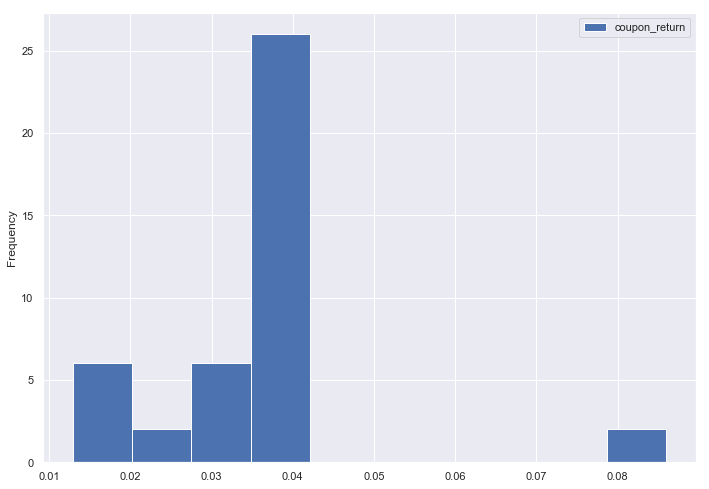

In [9]:
# look at the coupon return distribution
sns.set(rc={'figure.figsize':(11.7,8.27)})
pd.DataFrame(gov['coupon_return']).plot.hist()

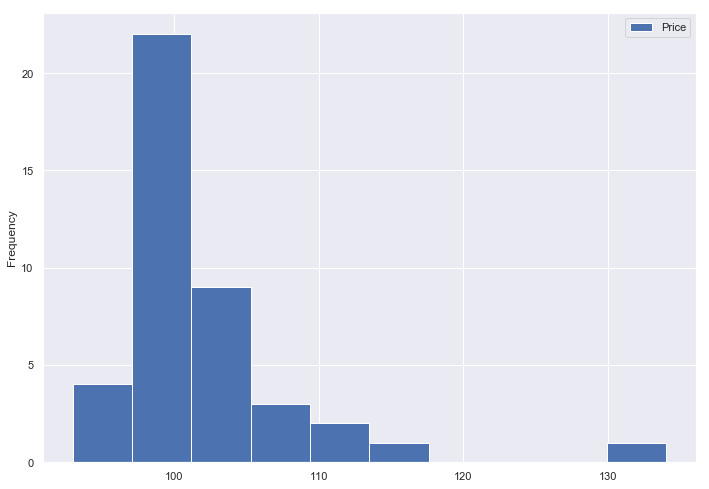

In [10]:
# look at the prices distribution
sns.set(rc={'figure.figsize':(11.7,8.27)})
pd.DataFrame(gov['Price']).plot.hist()

In [11]:
# Risk free rate
r_f = 0.0766

In [12]:
gov_bonds = pd.DataFrame()

In [13]:
print()
for i in gov.index: # the bond that is bought
    ret = []
    for j in gov.index: # the bond that is sold
        if j == i:
            ret.append(0)
            continue
        t = (gov.Coupon_date[i] - gov.Coupon_date[j]).days / 360 # days between coupons
        p = gov.price_rub[i] - gov.price_rub[j] # the difference between the price
#         print(t, p)
        # the coupon calculation
        if t > 0: # a bond that is bought on a bond that is sold
            coupon_future_i = present_value(gov.Coupon[i], r_f, abs(t))
            coupon_future_j = -future_value(gov.Coupon[j], r_f, abs(t))
        else: # a bond that is sold on a bond that is bounght
            coupon_future_i = future_value(gov.Coupon[i], r_f, abs(t))
            coupon_future_j = 0
        t_b = (current_date - gov.Coupon_date[j]).days / 360 # days between start and finish of strategy
        if p > 0: # the price of a bond that is bought is greater than the bond that is sold
            price_future = future_value(p, r_f, abs(t_b))
        else: # the price of a bond that is sold is greater than the bond that is bought
            price_future = -present_value(abs(p), r_f, abs(t_b))
        out = coupon_future_i + coupon_future_j + price_future - gov.ACI[i] + gov.ACI[j] # arbitrage result
        out /= gov.price_rub[i]
#         print(round(coupon_future_i,2), round(coupon_future_j,2), round(p,2), out, sep='\t')
        ret.append(out)
    gov_bonds[i] = ret
gov_bonds.index = gov.index

In [14]:
gov_bonds.head()

,RU000A100907,RU000A100C23,RU000A100EL3,RU000A0JX0J2,RU000A0ZYCK6,RU000A0JREQ7,RU000A0JS3W6,RU000A0JSMA2,RU000A0JTG59,RU000A0JTJL3,...,RU000A0JV7J9,RU000A0JX0H6,RU0002867854,RU0002868001,RU000A0D0G29,RU000A0GN9A7,RU000A0JPLH5,RU000A0JRTL6,RU000A0JVMH1,RU000A0ZYZ26
ISIN,,,,,,,,,,,,,,,,,,,,,
RU000A100907,0.000000,0.005314,0.010760,0.020321,0.016492,0.019334,0.023866,0.002130,0.025044,-0.017011,...,0.008124,0.017683,0.107213,-0.033703,-0.008302,-0.150737,-0.069040,-0.091937,0.131034,-0.032688
RU000A100C23,0.013709,0.000000,0.005446,0.015152,0.011300,0.014240,0.019362,-0.002886,0.019821,-0.022182,...,0.003026,0.012585,0.103844,-0.038327,-0.013584,-0.155212,-0.074199,-0.096994,0.127360,-0.037784
RU000A100EL3,0.007967,0.013390,0.000000,0.009851,0.005975,0.009017,0.014733,-0.008032,0.014466,-0.027487,...,-0.002201,0.007355,0.100366,-0.043083,-0.019001,-0.159842,-0.079502,-0.102198,0.123576,-0.043018
RU000A0JX0J2,0.017597,0.023028,0.028587,0.000000,-0.007476,-0.003156,-0.008609,-0.022359,0.004412,-0.043068,...,-0.012392,-0.007777,0.083355,-0.074823,-0.032501,-0.223711,-0.096548,-0.126746,0.110119,-0.070901
RU000A0ZYCK6,0.013108,0.018431,0.023913,0.038024,0.000000,0.039598,0.012369,-0.011026,0.041498,-0.034736,...,0.027533,0.002416,0.124789,-0.052713,0.007984,-0.185400,-0.081210,-0.106794,0.141822,-0.060234


In [17]:
gov_bonds.describe()

,RU000A100907,RU000A100C23,RU000A100EL3,RU000A0JX0J2,RU000A0ZYCK6,RU000A0JREQ7,RU000A0JS3W6,RU000A0JSMA2,RU000A0JTG59,RU000A0JTJL3,...,RU000A0JV7J9,RU000A0JX0H6,RU0002867854,RU0002868001,RU000A0D0G29,RU000A0GN9A7,RU000A0JPLH5,RU000A0JRTL6,RU000A0JVMH1,RU000A0ZYZ26
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.039655,0.044382,0.049250,0.073050,0.059302,0.066920,0.063199,0.046237,0.073219,0.021583,...,0.060711,0.061115,0.233587,0.001959,0.023208,-0.136475,-0.025680,-0.054807,0.228389,-0.020564
std,0.060277,0.060345,0.060504,0.070672,0.068582,0.073476,0.098258,0.076121,0.067990,0.068781,...,0.074693,0.073753,0.172610,0.091005,0.058776,0.061953,0.055212,0.058864,0.140506,0.064727
min,-0.095993,-0.090641,-0.085175,-0.068740,-0.071400,-0.070242,-0.085357,-0.087368,-0.065220,-0.103315,...,-0.080894,-0.069334,-0.005357,-0.141723,-0.101054,-0.317033,-0.147851,-0.182649,0.000000,-0.141502
25%,0.013765,0.018654,0.024139,0.038421,0.019046,0.032847,0.012429,0.000532,0.042696,-0.023924,...,0.026204,0.013743,0.124470,-0.049549,-0.004403,-0.178660,-0.073514,-0.101188,0.142176,-0.055774
50%,0.023659,0.028972,0.034404,0.056117,0.051542,0.051249,0.028806,0.028535,0.058762,0.013047,...,0.043598,0.048820,0.203603,-0.010744,0.013082,-0.135623,-0.020134,-0.060399,0.191752,-0.032609
75%,0.046507,0.051678,0.057042,0.084601,0.072287,0.085407,0.096124,0.065052,0.082549,0.037426,...,0.077143,0.082268,0.266069,0.032727,0.038261,-0.104910,0.002252,-0.019479,0.255591,0.003921
max,0.334431,0.338579,0.343145,0.408353,0.373543,0.410757,0.494194,0.400003,0.394875,0.331184,...,0.411839,0.398203,0.865694,0.416212,0.294627,0.002531,0.150169,0.097283,0.773967,0.270302


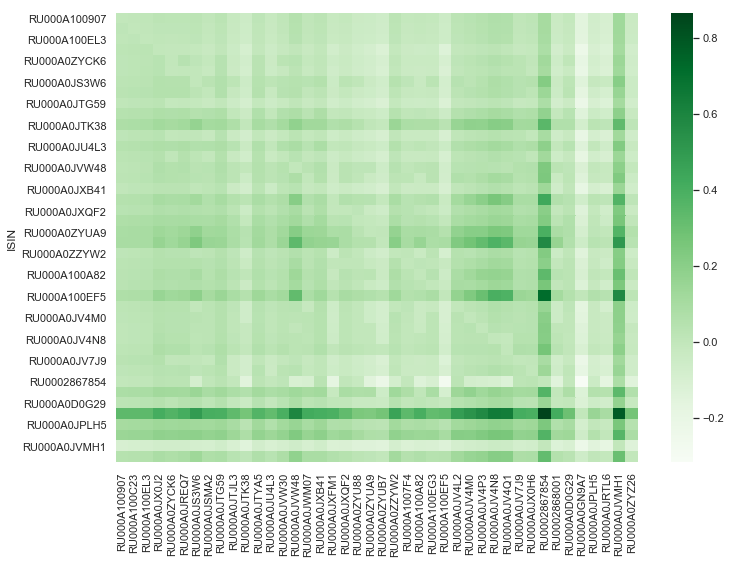

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(gov_bonds, cmap="Greens")

## Calculate arbitrage strategy for corportions bonds

In [27]:
# get corperment bonds data
corp = pd.read_csv('https://raw.githubusercontent.com/Aurilino/Python/master/Shortterm_bonds_arbitrage/Corp_bonds.csv ',
            sep=';', encoding='cp1251')
corp.index = corp.ISIN # set index as bonds isin
corp['Expiration_date'] = pd.to_datetime(corp['Expiration_date'], format='%d.%m.%Y', errors='ignore')
corp['Coupon_date'] = pd.to_datetime(corp['Coupon_date'], format='%d.%m.%Y', errors='ignore')
corp = corp[corp['Price'] > 0]
corp['price_rub'] = corp.Nominal * (corp['Price'] / 100) # Calculate the current value
corp['coupon_return'] = corp.Coupon / corp.price_rub #calculate coupon yield
corp = corp.drop('ISIN', axis=1)
corp.head()

,Name,Price,Nominal,Coupon,ACI,Coupon_date,Coupon_days,Expiration_date,price_rub,coupon_return
ISIN,,,,,,,,,,
XS1985081444,BCS_05/24,102.50,100000.0,4750.00,0.0,2019-08-24,129,2024-05-24,102500.0,0.046341
XS1833629253,BCS_07/21,95.00,100000.0,8500.00,0.0,2019-07-01,181,2021-07-01,95000.0,0.089474
XS1654237129,BCS_08/20,100.00,350000.0,20597.26,0.0,2019-08-16,181,2020-08-16,350000.0,0.058849
XS1859436070,BCS_08/21,73.03,100000.0,8500.00,0.0,2019-08-10,181,2021-08-10,73030.0,0.116391
XS1822383094,BCS_09/23,93.85,100000.0,5041.10,0.0,2019-09-27,184,2023-09-27,93850.0,0.053714


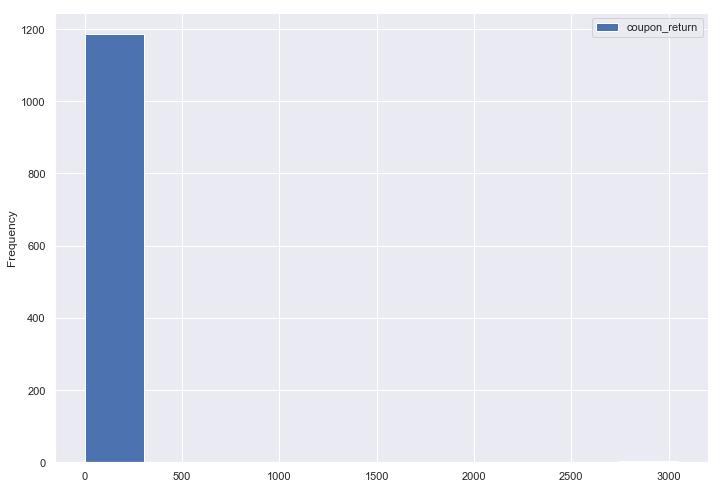

In [28]:
# look at the coupon return distribution
sns.set(rc={'figure.figsize':(11.7,8.27)})
pd.DataFrame(corp['coupon_return']).plot.hist()

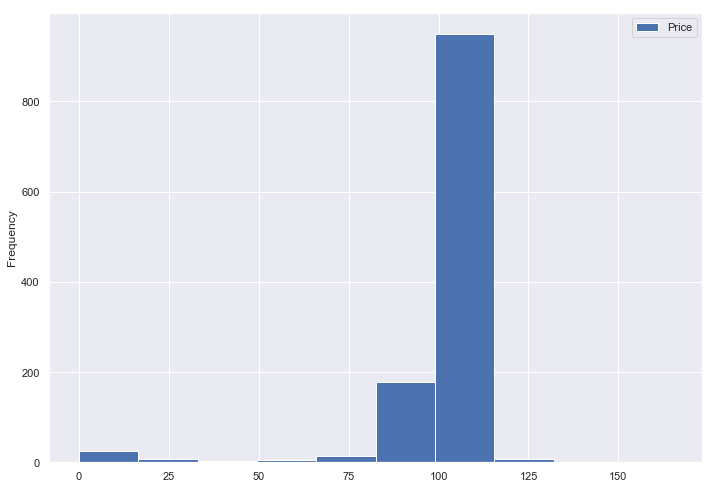

In [29]:
# look at the prices distribution
sns.set(rc={'figure.figsize':(11.7,8.27)})
pd.DataFrame(corp['Price']).plot.hist()

In [24]:
corp_bonds = pd.DataFrame()

In [26]:
print()
for i in corp.index: # the bond that is bought
    ret = []
    for j in corp.index: # the bond that is sold
        if j == i:
            ret.append(0)
            continue
        t = (corp.Coupon_date[i] - corp.Coupon_date[j]).days / 360 # days between coupons
        p = corp.price_rub[i] - corp.price_rub[j] # the difference between the price
#         print(t, p)
        # the coupon calculation
        if t > 0: # a bond that is bought on a bond that is sold
            coupon_future_i = present_value(corp.Coupon[i], r_f, abs(t))
            coupon_future_j = -future_value(corp.Coupon[j], r_f, abs(t))
        else: # a bond that is sold on a bond that is bounght
            coupon_future_i = future_value(corp.Coupon[i], r_f, abs(t))
            coupon_future_j = 0
        t_b = (current_date - corp.Coupon_date[j]).days / 360 # days between start and finish of strategy
        if p > 0: # the price of a bond that is bought is greater than the bond that is sold
            price_future = future_value(p, r_f, abs(t_b))
        else: # the price of a bond that is sold is greater than the bond that is bought
            price_future = -present_value(abs(p), r_f, abs(t_b))
        out = coupon_future_i + coupon_future_j + price_future - corp.ACI[i] # arbitrage result
        out /= corp.price_rub[i]
#         print(round(coupon_future_i,2), round(coupon_future_j,2), round(p,2), out, sep='\t')
        ret.append(out)
    corp_bonds[i] = ret
corp_bonds.index = corp.index

In [30]:
corp_bonds.head()

,XS1985081444,XS1833629253,XS1654237129,XS1859436070,XS1822383094,XS1434175730,XS1873963794,XS1903464391,XS1807420937,XS1708322133,...,RU000A0JWGT6,RU000A0JXR43,RU000A0ZZ7E6,RU000A0ZZNJ2,RU000A100CN3,RU000A0JWKL5,RU000A0JUQF8,RU000A0JWHN7,RU000A0JXS83,RU000A0ZZEM5
ISIN,,,,,,,,,,,,,,,,,,,,,
XS1985081444,0.000000,0.012545,0.775026,-0.281761,-0.088671,-0.291928,-0.317347,-0.023571,-0.267565,0.689099,...,-126.876626,-99.219860,-102.287447,-102.644502,-97.282284,-92.302759,-1050.393268,-95.398546,-99.672185,-100.313683
XS1833629253,0.035176,0.000000,0.763098,-0.302497,-0.051804,-0.251015,-0.274556,0.010293,-0.229407,0.691561,...,-129.717703,-101.445813,-104.594912,-100.220937,-99.475650,-90.136789,-1026.095394,-97.553228,-101.879139,-93.975153
XS1654237129,-2.543602,-2.564886,0.000000,-3.635079,-2.868101,-3.527813,-3.806261,-2.513836,-3.358407,-0.104722,...,-436.395774,-341.793640,-373.331463,-357.815449,-355.189527,-322.067871,-3639.051015,-348.377039,-343.331583,-345.509373
XS1859436070,0.253308,0.323727,0.833414,0.000000,0.185647,0.023608,0.021112,0.223360,0.032261,0.763938,...,-101.126854,-79.040594,-81.503472,-78.089445,-77.503425,-70.215177,-801.562271,-76.001718,-70.940117,-71.400473
XS1822383094,0.132755,0.103512,0.805861,-0.161917,0.000000,-0.187566,-0.203918,0.058260,-0.169042,0.719683,...,-115.247979,-90.107863,-92.896313,-88.989599,-88.346489,-79.991135,-911.622326,-86.633920,-90.519380,-91.103131


In [31]:
corp_bonds.describe()

,XS1985081444,XS1833629253,XS1654237129,XS1859436070,XS1822383094,XS1434175730,XS1873963794,XS1903464391,XS1807420937,XS1708322133,...,RU000A0JWGT6,RU000A0JXR43,RU000A0ZZ7E6,RU000A0ZZNJ2,RU000A100CN3,RU000A0JWKL5,RU000A0JUQF8,RU000A0JWHN7,RU000A0JXS83,RU000A0ZZEM5
count,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,...,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000,1188.000000
mean,0.616831,0.625490,0.963281,0.499507,0.578027,0.475318,0.507214,0.576969,0.465700,0.895863,...,-59.878298,-46.710404,-48.190364,-46.357674,-45.804509,-41.625883,-479.514323,-44.905666,-46.917653,-47.213483
std,13.703461,14.784034,4.023631,19.228092,14.972022,17.424515,18.786805,13.402980,16.600817,4.192570,...,1773.163352,1389.652658,1432.196663,1373.273688,1362.805270,1236.180757,13927.491683,1336.717416,1395.871812,1404.672680
min,-469.609095,-506.685161,-136.955483,-659.332628,-512.955068,-597.189055,-643.887748,-459.129494,-568.931096,-142.776000,...,-60911.990069,-47737.352191,-49198.722822,-47153.752147,-46814.943163,-42446.171500,-478232.481704,-45918.753768,-47951.002480,-48253.347418
25%,1.044981,1.088482,1.063761,1.111440,1.051106,1.031406,1.107674,0.999069,0.996851,1.005144,...,-0.283450,-0.007551,-0.041135,0.002411,0.010778,0.112699,-9.213825,0.030568,-0.010146,-0.016674
50%,1.055036,1.098690,1.074152,1.122279,1.060939,1.041471,1.118117,1.008447,1.006309,1.014701,...,-0.250689,0.016675,-0.013678,0.031391,0.036791,0.141286,-8.830383,0.058202,0.009591,-0.000509
75%,1.066176,1.110268,1.085240,1.134336,1.072377,1.053404,1.130599,1.018869,1.016987,1.025249,...,-0.215206,0.040153,0.009201,0.055084,0.060844,0.168078,-8.449265,0.082096,0.033911,0.021102
max,3.894088,4.056213,3.945935,4.150381,3.919124,3.921933,4.135944,3.723518,3.721738,3.728646,...,2.822022,3.025807,2.996995,3.041255,3.040704,3.157313,2.016220,3.065442,3.017700,3.003687
